# Vectorised code - what and why?

We have now had fairly extensive practise in iteratively creating solutions to problems using for loops. Thus far all our problems have been mathematically quite straightforward, and not very computationally intensive. As you begin to move on from your taught modules and into current research, you may find yourselves solving larger and more complex problems, at which point you will start to discover that for-loops have a fundamental weakness - speed!

In a nutshell, there are two issues keeping loops slow:

1. Producing solutions to a large problem one loop iteration at a time means that our scripts and functions spend a lot of time doing stuff other than actually solving the problem we want them to solve - e.g. shuffling data around between variables in each loop iteration, or storing the result of the current loop's calculations in a (sometimes temporary) variable.

2. loops (at least in Python) are not generally able to take advantage of the parallel computing capabilities of modern-day computers, and thus must literally compute a solution one loop iteration at a time. Vectorised functions tend to be optimised to spread their computations over multiple processors/threads, which can be much faster!

These issues become especially pronounced in the case of nested loops - which often appear in more spatially-explicit problems or time-dependent ones.

rather than expecting you to simply take my word for it, the following two examples will showcase the difference in runtime between a loop method and a vectorised method using numpy. The first is a relatively simple (if artificial) problem, intended to demonstrate basically at-a-glace the difference between the two approaches. The second is taken from current research on metabolic models of bacterial communities<sup>[2]</sup>.

[1] see the `multiprocessing` package for one way around this!

[2] thanks to Emma Cavan (https://www.imperial.ac.uk/people/e.cavan/research.html) in Samraat's lab for bringing this model to my attention.

## Example 1: Vectorising a simple calculation of 2 arrays

Let us imagine we have two simple 1D arrays $a = (a_1, a_2, ... , a_N)$ and $b = (b_1, b_2, ... ,b_N)$, each of length N, and that we want to calculate a new array $c$ in which each entry is just the product of the two corresponding entries in $a$ and $b$:

$$c = (a_1 \times b_1, a_2 \times b_2, ... , a_N \times b_N)$$

This operation is called the *entrywise* product of $a$ and $b$.

Below are a loop-based function and a vectorised function to calculate the entrywise product of two 1D arrays of the same length. We will test them both on larger and larger 1D arrays to see how the vectorised approach is faster.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def loop_product(a, b):
    N = len(a)
    c = np.zeros(N)
    for i in range(N):
        c[i] = a[i] * b[i]   
    return c


def vect_product(a, b):
    return np.multiply(a, b)

The `multiply` function from numpy is a vectorised implementation of the elementwise product that we have explicitly written in the function `loop_product` above it. In general, numpy is an excellent choice for vectorised implementations of functions involving matrix maths (or maths using higher-dimensional analogues of matricies).

Let's try comparing the runtimes of `loop_product` and `vect_product` on increasingly large randomly-generated 1D arrays:


Set N=1
Loop method took 0 ms on average.
Vectorised method took 0 ms on average.

Set N=100
Loop method took 0 ms on average.
Vectorised method took 0 ms on average.

Set N=10000
Loop method took 3 ms on average.
Vectorised method took 0 ms on average.

Set N=1000000
Loop method took 358 ms on average.
Vectorised method took 4 ms on average.

Set N=10000000
Loop method took 3841 ms on average.
Vectorised method took 72 ms on average.


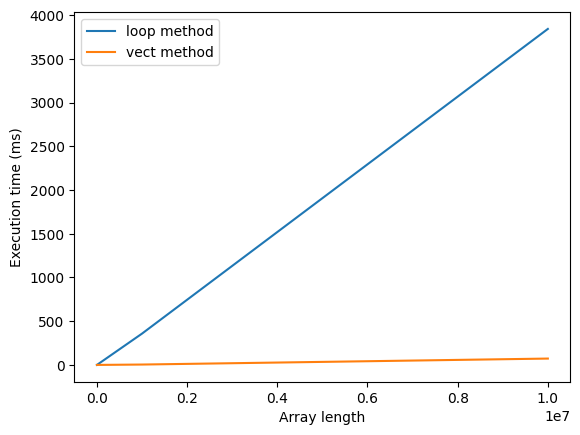

In [3]:
import timeit

array_lengths = [1, 100, 10000, 1000000, 10000000]
t_loop = []
t_vect = []

for N in array_lengths:
    print("\nSet N=%d" %N)
    #randomly generate our 1D arrays of length N
    a = np.random.rand(N)
    b = np.random.rand(N)
    
    # time loop_product 3 times and save the mean execution time.
    timer = timeit.repeat('loop_product(a, b)', globals=globals().copy(), number=3)
    t_loop.append(1000 * np.mean(timer))
    print("Loop method took %d ms on average." %t_loop[-1])
    
    # time vect_product 3 times and save the mean execution time.
    timer = timeit.repeat('vect_product(a, b)', globals=globals().copy(), number=3)
    t_vect.append(1000 * np.mean(timer))
    print("Vectorised method took %d ms on average." %t_vect[-1])

    
    
# compare the timings in a plot
plt.figure()
plt.plot(array_lengths, t_loop, label="loop method")
plt.plot(array_lengths, t_vect, label="vect method")
plt.xlabel("Array length")
plt.ylabel("Execution time (ms)")
plt.legend()
plt.show()


## Example 2: A resource-consumer model of Bacterial Carbon Uptake

The above example clearly shows that some operations can be vastly accelerated with vectorised code - but you aren't going to spend your research projects computing the elementwise products of absurdly long 1D arrays. This example will show how the vectorised approach is applicable to biologically relevant problems and real, ongoing research.

Do not worry too much about the equations themselves, the 

Imagine we have $N$ different bacterial species (our consumers) in an environment consisting of $M$ carbon sources (our resources). 

### consumer growth rate:

In reality, each species will uptake carbon from the different sources at different rates, as well as respiring and losing carbon to the environment at different rates. This yields a complex relationship between overall per-species growth rate and resource availability, which we can describe with:

\begin{align}
    \frac{1}{C_i}\frac{dC_i}{dt} = (\sum_{j=1}^M u_{ij} S_j  (1 - {p_{r}}_j - \sum_{k=1}^{M} l_{jk})) - r_{i}
\end{align}

where:

* $C = $ vector of bacterial populations
* $S = $ vector of carbon output from different sources,
* $u = $ matrix of carbon-uptake rates for each species and carbon source,
* $p_r = $ vector of respiratory carbon loss,
* $l = $ matrix of non-respiratory carbon loss,
* $r = $ vector of maintenance cost of growth.

### resource availability:

The change in carbon resource avaliblity can be attributed either to abiotic processes (which we represent here through the constant term $\rho_j$) or through the activity of the bacterial community which takes up resource $j$ at the rate $U_j$ and releases it (via the inefficency of uptake) through the $L_j$ term:

\begin{align}
    \frac{dS_j}{dt} = \rho_j - U_j + L_j
\end{align}

How do the vectors $U_j$ and $L_j$ relate to the matricies $u$ and $l$ above? We can get the rates of uptake and release by the community by summing across all $N$ species in the community and across all $M$ resources which they release as a result of the $L_j$ term:

\begin{align}
    \frac{dS_j}{dt} = \rho_j - 
                      \sum_{i = 1}^{N} \left( S_j C_i u_{ij}  - \sum_{k = 1}^{N} C_i S_k u_{ik} l_{kj} \right),
\end{align}

where:
* $\rho =$ constant vector of carbon resource change due to abiotic processes,
* $C, S, u, l$ are the same as above.

\begin{align}
    \frac{1}{C_i}\frac{dC_i}{dt} = (\sum_{j=1}^M u_{ij} S_j  (1 - {p_{r}}_j - \sum_{k=1}^{M} l_{jk})) - r_{i}
\end{align}
\begin{align}
    \frac{dS_j}{dt} = \rho_j - 
                      \sum_{i = 1}^{N} \left( S_j C_i u_{ij}  - \sum_{k = 1}^{N} C_i S_k u_{ik} l_{kj} \right),
\end{align}

### Loop and vector forms of these equations:

Since $\frac{dC_i}{dt}$ and $\frac{dS_j}{dt}$ are defined individually for each consumer $i$ and each resource $j$, and since they consist simply of matrix arithmetic, we could define them using for loops:

In [4]:
def dCdt_loop(C, S, u, l, pr, r):
    N = C.shape[0]
    M = S.shape[0]
    
    dC_dt = np.zeros(N)
    lsum = np.sum(l, axis=1)
    for i in range(N):
        term1 = 0
        for j in range(M):
            term1 += u[i, j] * S[j] * (1 - pr[j] - lsum[j])
        dC_dt[i] = C[i] * (term1 - r[i])
    return dC_dt
        

def dSdt_loop(C, S, u, l, rho):
    N = C.shape[0]
    M = S.shape[0]
    
    dS_dt = np.zeros(M)
    for j in range(M):
        SCu = 0
        for i in range(N):
            CSul = 0
            for k in range(M):
                CSul += C[i] * S[k] * u[i, k] * l[k, j]
            SCu += S[j] * C[i] * u[i, j] - CSul
        dS_dt[j] = rho[j] - SCu
    return dS_dt

It should be immediately clear why this system might be a good candidate for vectorisation - look at those all those nested loops! Now consider that this is just for calculating the change in $C$ and in $S$ at each timestep, and you can see how simulating this whole system over many timesteps with the loop approach could get very painful if the number of bacterial species $N$ and/or carbon sources $M$ is large.

Luckily, since all of the above are matrix operations, we can vectorise the functions with Numpy:

In [5]:
def dCdt_vect(C, S, u, l, pr, r):
    Sl = (u - pr - np.sum(l, axis=1)) * S
    uSl = np.sum(Sl * u, axis=1) - r
    dCdt = C * uSl
    return dCdt

def dSdt_vect(C, S, u, l, rho):
    return rho - np.multiply((C @ u).transpose(), S) + np.einsum('i,k,ik,kj->j', C, S, u, l)

Do not panic if you can't easily interpret these numpy expressions! This is a relatively complex example and if you aren't familiar with the relevant linear algebra then it will seem much spookier than it truly is. The point of this example is to show a real-world scenario in which vectorising code will generate much quicker results, hopefully with the idea of motivating you to look into vectorising your own code in your own research.

### Comparing the loop and vectorised models:

We will now run two simulations of our system of bacteria and carbon sources. The initial values and all equation parameters will be identical - the only difference will be that one will be run with the loop functions, and the other with the vectorised functions. We will compare the outputs (to make sure they are the same!) and the execution times.

First we will import some extra functions and set up the simulation parameters.

In [6]:
from scipy.integrate import odeint
import matplotlib.pylab as pie
import time

# set up simulation parameters
N = 200
M = 100

u = np.zeros([N,M])
np.fill_diagonal(u,1)

r = np.full([N], (0.3))

pr = np.full([M], (0.1))

l = np.zeros([M,M])
for i in range(M-1):
    l[i,i+1] = 0.3

rho = np.zeros(M)

t = np.linspace(0,100,101)

x0 = np.concatenate((np.full([N], (0.1)),np.full([M], (1.0))))  # initial values for C and S



def model_loop(pops, t, N, M):
    x = pops
    C = x[0:N] # consumer
    S = x[N:N+M] # resources
    
    dCdt = dCdt_loop(C, S, u, l, pr, r)
    dSdt = dSdt_loop(C, S, u, l, rho)
    return np.array(np.concatenate((dCdt, dSdt)))


def model_vect(pops, t, N, M):
    x = pops
    
    C = x[0:N] # consumer
    S = x[N:N+M] # resources
    
    dCdt = dCdt_vect(C, S, u, l, pr, r)
    dSdt = dSdt_vect(C, S, u, l, rho)

    return np.array(np.concatenate((dCdt, dSdt)))

Now run the two simulations:

## WARNING: THIS WILL TAKE TIME.

Expect the cell to execute for at least 5 minutes. Go and make a cup of tea while you wait. If it takes longer than 10 minutes then interrupt the cell with the stop button at the top of the notebook window, and try running with N = 50, M = 25 instead. 

In [ ]:
plt.close('all')

## loop model
starttime = time.time()
pops_loop = odeint(model_loop, y0=x0, t=t, args=(N, M))
time_loop = time.time() - starttime

# vectorised model
starttime = time.time()
pops_vect = odeint(model_vect, y0=x0, t=t, args=(N, M))
time_vect = time.time() - starttime

print("Loop model took %6.3f s." %time_loop)
print("Vectorised model took %6.3f s." %time_vect)

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(121)
ax1.plot(t, pops_loop[:,0], 'g-', label = 'resources (loop)', linewidth=0.7)
ax1.plot(t, pops_loop[:,N], 'b-', label = 'consumers (loop)', linewidth=0.7)
ax1.plot(t, pops_loop[:,0:N], 'g-', linewidth=0.7)
ax1.plot(t, pops_loop[:,N:N+M], 'b-', linewidth=0.7)
ax1.legend()
ax1.grid
ax1.set_ylabel('Population density')
ax1.set_xlabel('Time')
ax1.set_title('LOOP MODEL')

ax2 = fig.add_subplot(122)
ax2.plot(t, pops_vect[:,0], 'g--', label = 'resources (vect)', linewidth=0.7)
ax2.plot(t, pops_vect[:,N], 'b--', label = 'consumers (vect)', linewidth=0.7)
ax2.plot(t, pops_vect[:,0:N], 'g--', linewidth=0.7)
ax2.plot(t, pops_vect[:,N:N+M], 'b--', linewidth=0.7)
ax2.legend()
ax2.grid
ax2.set_ylabel('Population density')
ax2.set_xlabel('Time')
ax2.set_title('VECTOrISED MODEL')

We can see from the plots that the outputs of the two models are identical, but the execution time varies dramatically. Imagine we wanted to run these models a large number of times with varying initial conditions and/or parameters, to see how our populations would behave and evolve under different environmental conditions. running just 10 simulations in loop-mode would take close to an hour, whereas in vectorised mode we could run hundreds of simulations in mere minutes.

# When to vectorise?

We have seen that vectorising your code can have it running in a fraction of the time it otherwise would - why not always vectorise then?

Generally, you should follow the same principles as with any code profiling...don't spend time speeding up code that isn't slow in the first place, or code which you will probably not need to run more than a small number of times.

## "No free lunch!"

There are trade-offs to vectorising, most notably memory useage. One downsides of calculating many steps simultaneously is that your computer needs to hold much more in memory in order to do it. If you try to vectorise a problem thats *too* large, you will probably run into memory errors. One easy example is to re-run example 1 above, but **even bigger**:

In [ ]:
N = 1000000000

a = np.random.rand(N)
b = np.random.rand(N)
c = vect_product(a, b)

# if no error, remove a, b, c from memory.
del a
del b
del c

This will almost certainly return a memory error (i.e. your computer ran out of rAM in which to store the entire of the very large arrays $a$, $b$ and $c$ while it was still calculating (if you didnt get an error, try again with an extra 0 in $N$).

Again, this is a rather contrived example - you probably won't be taking element-wise products of arrays with a billion entries in your research - but more complex problems can easily become too big for memory while still remaining biologically reasonable!<sup>[3]</sup>

## When *can* you vectorise?

Note that not every system is vectorisable! You cannot generally vectorise a loop over time, for example. In our example 2 above, we vectorised everything that happens *within* a given timestep, but computing the future state of the system using its current state we did not vectorise (in fact `odeint` did this bit for us, but it still had to do it timestep-by-timestep).

This makes sense - imagine trying to simulate a resource-consumer model like ours above at some timesteps $(t_0, t_1, t_2,...)$. You can't start computing the population sizes in any order you like, since the state at each $t_n$ depends on the state before it -- you have to start with $t_1$, then $t_2$, and so on in numerical order.

[3] Check out the CMEE course on High Performance Computing to learn about using Imperial's supercomputing cluster to run extremely large problems.